In [1]:
import pandas as pd
import numpy as np
import math
import sys
import os
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

from scipy.stats import wilcoxon, friedmanchisquare, rankdata
from Orange.evaluation import compute_CD, graph_ranks

In [2]:
def report(measure):

    results_valid = pd.DataFrame(columns = ['Dataset', 'Config', 'Without', 'IRT-SR', 'Reweighing'])
    results_test = pd.DataFrame(columns = ['Dataset', 'Config',  'Without', 'IRT-SR', 'Reweighing'])
    f1 = pd.DataFrame(columns = ['Dataset', 'Config',  'Without', 'IRT-SR', 'Reweighing'])
    count = 0

    for name in ['arrhythmia', 'adult', 'bank', 'compasmen', 'compaswomen', 'contraceptive', 
                 'crack', 'german', 'heart', 'heroin', 'student', 'titanic']:
        for config in ['ada', 'dt', 'rf', 'svm', 'xgb']:
            ''' abre os resultados '''
            if os.path.exists('../Experiments/' + name + '_' + config + '_validation.csv'):
                validation = pd.read_csv('../Experiments/' + name + '_' + config + '_validation.csv', sep=';', index_col=0) 
                test = pd.read_csv('../Experiments/' + name + '_' + config + '_test.csv', sep=';', index_col=0)
                ''' Calcula ratio odds '''
                validation['ratio_odds'] = (validation['ratio_fpr'] + validation['ratio_recall'])/2
                test['ratio_odds'] = (test['ratio_fpr'] + test['ratio_recall'])/2

                values_valid = []
                values_valid.append(name)
                values_valid.append(config)

                values_test = []
                values_test.append(name)
                values_test.append(config)
                
                values_f1 = []
                values_f1.append(name)
                values_f1.append(config)

                for preprocessing in ['without', 'irt', 'reweighing']:

                    aux_validation = validation.loc[validation['preprocessing'] == preprocessing].copy()
                    aux_validation = aux_validation.sort_values(by=['clf_name'])
                    aux_validation = aux_validation.reset_index()

                    aux_test = test.loc[test['preprocessing'] == preprocessing].copy()
                    aux_test = aux_test.sort_values(by=['clf_name'])
                    aux_test = aux_test.reset_index()

                    idx = aux_validation[measure].idxmax()
                    values_valid.append(aux_validation.loc[idx, measure])
                    values_test.append(aux_test.loc[idx, measure])
                    values_f1.append(aux_test.loc[idx, 'f1_macro'])
                    
                
                results_valid.loc[count] = values_valid
                results_test.loc[count] = values_test
                f1.loc[count] = values_f1
                count += 1
                
    return results_valid, results_test, f1

In [3]:
def cd(results, conjunto, filename):
    # ajusta a entrada de dados para o teste
    df = results[['Without', 'IRT-SR', 'Reweighing']]
    algorithms_names = df.columns
    results_array = df.values

    # calcula os ranks
    ranks_test = np.array([rankdata(-p) for p in results_array])

    # calcula a média dos ranks
    average_ranks = np.mean(ranks_test, axis=0)
    print('Conjunto de', conjunto)
    print('\n'.join('({}) Média dos ranks: {}'.format(a, r) for a, r in zip(algorithms_names, average_ranks)))
    
    # This method computes the critical difference for Nemenyi test
    cd = compute_CD(average_ranks, n=len(df), alpha='0.05', test='nemenyi')
    print('CD = ', cd)
    # This method generates the plot.
    graph_ranks(average_ranks, names=algorithms_names, cd=cd, width=7, textspace=1.25, reverse=False, 
                filename= filename + '.pdf')

## Demographic Parity

In [4]:
valid, test, f1 = report('ratio_selection_rate')

In [63]:
test.groupby(by='Dataset').mean()

,Without,IRT-SR,Reweighing
Dataset,,,
adult,0.318367,0.364850,0.365383
arrhythmia,0.707501,0.823119,0.759706
bank,0.505766,0.563129,0.618133
compasmen,0.723652,0.835983,0.763966
compaswomen,0.824431,0.856458,0.807183
contraceptive,0.947313,0.948311,0.920120
crack,0.524970,0.592183,0.234014
german,0.836111,0.834120,0.827840
heart,0.534098,0.522140,0.631583


In [64]:
test.groupby(by='Dataset').std()

,Without,IRT-SR,Reweighing
Dataset,,,
adult,0.020286,0.040150,0.034581
arrhythmia,0.198079,0.129150,0.150967
bank,0.088971,0.165131,0.057381
compasmen,0.058981,0.110313,0.064335
compaswomen,0.220322,0.053181,0.173741
contraceptive,0.046185,0.039405,0.043520
crack,0.399321,0.341367,0.214725
german,0.094621,0.103305,0.107867
heart,0.138232,0.052888,0.168312


In [65]:
test.std()

Without       0.267336
IRT-SR        0.244480
Reweighing    0.250442
dtype: float64

Conjunto de Test
(Without) Média dos ranks: 2.3666666666666667
(IRT-SR) Média dos ranks: 1.7083333333333333
(Reweighing) Média dos ranks: 1.925
CD =  0.42789930191580505


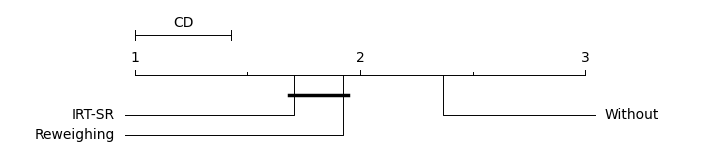

In [66]:
cd(test, 'Test', 'cd_demographic')

## Equal Opportunity

In [67]:
valid, test, f1 = report('ratio_recall')

In [68]:
test.groupby(by='Dataset').mean()

,Without,IRT-SR,Reweighing
Dataset,,,
adult,0.861980,0.902521,0.910849
arrhythmia,0.811731,0.856113,0.877775
bank,0.883419,0.939242,0.823610
compasmen,0.786229,0.885687,0.808924
compaswomen,0.836930,0.961588,0.820810
contraceptive,0.933521,0.914530,0.956901
crack,0.598060,0.210807,0.167273
german,0.903352,0.908604,0.919180
heart,0.787290,0.775993,0.851601


In [69]:
test.groupby(by='Dataset').std()

,Without,IRT-SR,Reweighing
Dataset,,,
adult,0.018949,0.043485,0.029729
arrhythmia,0.102917,0.064273,0.090805
bank,0.114085,0.045663,0.053087
compasmen,0.037742,0.082041,0.035875
compaswomen,0.220968,0.031938,0.231759
contraceptive,0.059911,0.053956,0.050282
crack,0.428010,0.295429,0.374033
german,0.058344,0.061035,0.069467
heart,0.093300,0.031252,0.057639


In [70]:
test.mean()

Without       0.749914
IRT-SR        0.785007
Reweighing    0.758026
dtype: float64

Conjunto de Test
(Without) Média dos ranks: 2.2583333333333333
(IRT-SR) Média dos ranks: 1.8583333333333334
(Reweighing) Média dos ranks: 1.8833333333333333
CD =  0.42789930191580505


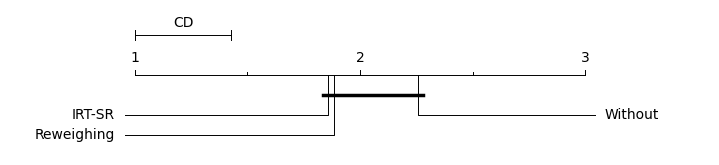

In [71]:
cd(test, 'Test', 'cd_equal_op')

## Equalized Odds

In [72]:
valid, test, f1 = report('ratio_odds')

In [73]:
test.groupby(by='Dataset').mean()

,Without,IRT-SR,Reweighing
Dataset,,,
adult,0.540205,0.604133,0.611082
arrhythmia,0.676768,0.783513,0.748735
bank,0.655361,0.726805,0.791102
compasmen,0.776630,0.859025,0.826770
compaswomen,0.817173,0.818611,0.783961
contraceptive,0.880985,0.913770,0.886191
crack,0.388586,0.441868,0.236854
german,0.766401,0.802929,0.818991
heart,0.530008,0.566748,0.553151


In [74]:
test.groupby(by='Dataset').std()

,Without,IRT-SR,Reweighing
Dataset,,,
adult,0.027858,0.043402,0.046438
arrhythmia,0.160597,0.092936,0.163376
bank,0.041384,0.060970,0.107721
compasmen,0.068419,0.079264,0.070410
compaswomen,0.161878,0.097411,0.206159
contraceptive,0.003526,0.138939,0.036327
crack,0.400204,0.295489,0.238264
german,0.148706,0.119976,0.106545
heart,0.058387,0.061081,0.116796


In [75]:
f1.std()

Without       0.117615
IRT-SR        0.112665
Reweighing    0.119230
dtype: float64

Conjunto de Test
(Without) Média dos ranks: 2.3833333333333333
(IRT-SR) Média dos ranks: 1.75
(Reweighing) Média dos ranks: 1.8666666666666667
CD =  0.42789930191580505


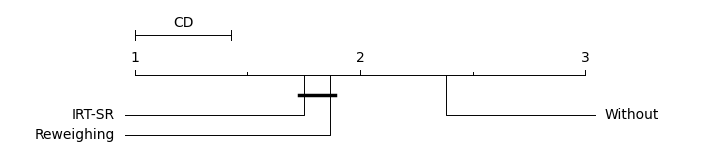

In [76]:
cd(test, 'Test', 'cd_equal_odds')